In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R

In [11]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Description

In this notebook, I study the state of awakeness among monkeys.

## Fonctions utiles

In [4]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

In [5]:
def generate_vector_distance_inter_zones(X,Y):
    a,b = X.shape
    c,d = Y.shape
    distance = np.zeros((a,c))
    for i in range(a):
        for j in range(c):
            distance[i,j] = np.linalg.norm(X[i,:] - Y[j,:])
    return distance

In [6]:
def display(states,li_titles):
    fig = plt.figure(figsize=(11, 11))
    
    # setting values to rows and column variables
    n = len(states)
    rows = int(np.sqrt(n))+1
    columns = n // (rows-1)
    
    for i in range(n):
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(states[i])
        plt.axis('off')
        plt.title(li_titles[i])

In [5]:
cd /neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs

/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs


In [6]:
ls

input_flat.npy*  labels.tsv*  metadata.tsv*     structural.txt*
inputs.npy*      labels.txt*  regionalmap.pdf*


## Data Loading

Dans le train, on garde les singes 'almira', 'khali', 'kimiko', 'rana'.
Dans le test, on utilise 'jade'.

In [124]:
labels = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/structural.txt")

In [165]:
datadir = "/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs"
file = tembedding.datasets.Dataset(name = "anesthesia",datasetdir = datadir)

Loading dataset:
  Loading anesthesia dataset:
  path: /neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs
  DFC file: /neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy
  description file: /neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv
       monkey    run   session         condition  matlab_kmeans_labels   
0      almira  run14  20130830             awake                     0  \
1      almira  run14  20130830             awake                     0   
2      almira  run14  20130830             awake                     0   
3      almira  run14  20130830             awake                     0   
4      almira  run14  20130830             awake                     0   
...       ...    ...       ...               ...                   ...   
72379    rana  run14  20160909  deep-sevoflurane                     6 

In [7]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

In [8]:
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc = dfc.reshape((-1, n_wins, 82, 82))
assert len(dfc) == n_runs
bsk = meta["matlab_kmeans_labels"].values
print(bsk.shape)

(72384,)


In [1]:
meta.loc[464*24]

NameError: name 'meta' is not defined

In [193]:
meta["monkey"].unique()

array(['almira', 'jade', 'khali', 'kimiko', 'rana'], dtype=object)

In [200]:
meta[meta["monkey"] == "rana"]["condition"].unique()

array(['ketamine', 'light-propofol', 'deep-propofol', 'light-sevoflurane',
       'deep-sevoflurane'], dtype=object)

In [199]:
meta[meta["monkey"] == "jade"]["condition"].unique()

array(['awake', 'light-propofol', 'deep-propofol', 'light-sevoflurane',
       'deep-sevoflurane'], dtype=object)

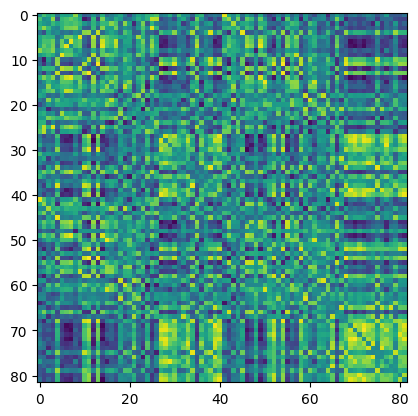

In [10]:
plt.imshow(dfc[100,10,:,:])

## Première analyse

In [6]:
def delta(dataset):
    n_sessions,T,_ = dataset.shape
    res = np.zeros((n_sessions,T-1))
    for session in range(n_sessions):
        for i in range(T-1):
            res[session,i] = np.linalg.norm(dataset[session,i+1,:] - dataset[session,i,:])
    return res

(array([6.000e+00, 3.000e+00, 5.000e+00, 1.500e+01, 3.200e+01, 8.400e+01,
        2.010e+02, 3.560e+02, 5.660e+02, 9.980e+02, 1.885e+03, 2.751e+03,
        4.122e+03, 5.599e+03, 6.758e+03, 6.738e+03, 6.109e+03, 5.214e+03,
        4.454e+03, 4.021e+03, 3.686e+03, 3.482e+03, 3.228e+03, 2.938e+03,
        2.395e+03, 1.955e+03, 1.435e+03, 1.112e+03, 7.720e+02, 5.530e+02,
        2.680e+02, 1.970e+02, 1.060e+02, 6.000e+01, 3.300e+01, 2.800e+01,
        1.900e+01, 1.600e+01, 9.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.39391644, 0.48980954, 0.58570264, 0.68159573, 0.77748883,
        0.87338193, 0.96927503, 1.06516813, 1.16106123, 1.25695433,
        1.35284743, 1.44874053, 1.54463363, 1.64052673, 1.73641983,
        1.83231293, 1.92820603, 2.02409912, 2.11999222, 2.21588532,
        2.31177842, 2.40767152, 2.50356462, 2.59945772, 2.69535082,
        2.79124392, 2.88713702, 2.98

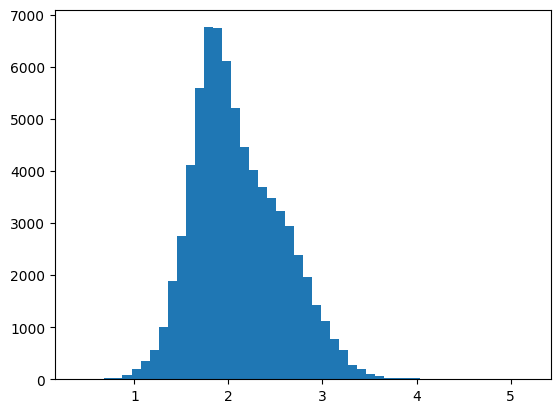

In [21]:
list_delta = delta(dataset)
plt.hist(np.ndarray.flatten(list_delta),bins=50)

(array([4.6400e+02, 1.0000e+01, 3.1800e+02, 5.3200e+02, 1.4600e+02,
        2.6800e+02, 3.4800e+02, 3.4000e+02, 2.9000e+02, 2.6800e+02,
        3.9000e+02, 3.0400e+02, 3.0600e+02, 3.7800e+02, 3.4800e+02,
        3.0800e+02, 4.2600e+02, 3.3600e+02, 4.1000e+02, 4.2600e+02,
        4.0200e+02, 5.0400e+02, 5.2600e+02, 6.7000e+02, 9.0600e+02,
        1.3480e+03, 2.3260e+03, 3.6800e+03, 5.4200e+03, 8.4380e+03,
        1.3438e+04, 1.7512e+04, 1.9772e+04, 2.2192e+04, 2.1272e+04,
        1.8152e+04, 1.4788e+04, 1.2444e+04, 1.0506e+04, 8.4520e+03,
        7.0960e+03, 5.7420e+03, 4.3220e+03, 3.2780e+03, 2.1080e+03,
        1.4300e+03, 9.9600e+02, 6.5600e+02, 2.6000e+02, 4.4000e+01]),
 array([ 0.        ,  0.54740723,  1.09481447,  1.6422217 ,  2.18962893,
         2.73703617,  3.2844434 ,  3.83185063,  4.37925787,  4.9266651 ,
         5.47407233,  6.02147957,  6.5688868 ,  7.11629403,  7.66370127,
         8.2111085 ,  8.75851573,  9.30592297,  9.8533302 , 10.40073743,
        10.94814467, 11.49

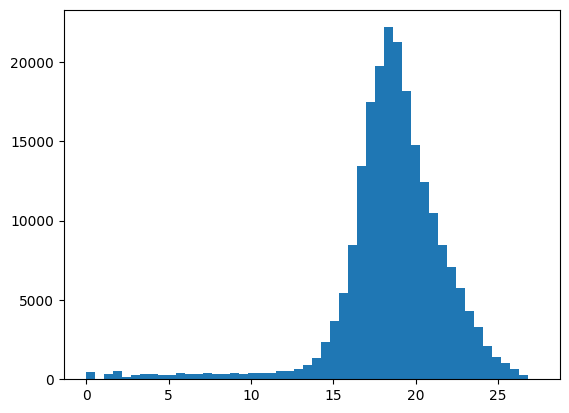

In [16]:
distance = torch.from_numpy(package.preprocessing.generate_vector_distance(dataset[10,:,:],distance="euclidean"))
plt.hist(distance.flatten(),bins=50)

(array([  11.,   27.,   36.,   38.,   52.,   65.,  102.,  144.,  216.,
         288.,  377.,  423.,  449.,  545.,  624.,  664.,  721.,  756.,
         892.,  896.,  948.,  957.,  941.,  994., 1088., 1190., 1225.,
        1116., 1015.,  943.,  845.,  726.,  662.,  577.,  560.,  512.,
         476.,  398.,  386.,  303.,  267.,  209.,  168.,  136.,  116.,
          81.,   59.,   36.,   18.,   22.]),
 array([12.6623795 , 13.15559205, 13.64880461, 14.14201717, 14.63522972,
        15.12844228, 15.62165484, 16.11486739, 16.60807995, 17.1012925 ,
        17.59450506, 18.08771762, 18.58093017, 19.07414273, 19.56735529,
        20.06056784, 20.5537804 , 21.04699296, 21.54020551, 22.03341807,
        22.52663063, 23.01984318, 23.51305574, 24.0062683 , 24.49948085,
        24.99269341, 25.48590597, 25.97911852, 26.47233108, 26.96554364,
        27.45875619, 27.95196875, 28.4451813 , 28.93839386, 29.43160642,
        29.92481897, 30.41803153, 30.91124409, 31.40445664, 31.8976692 ,
        32.39088

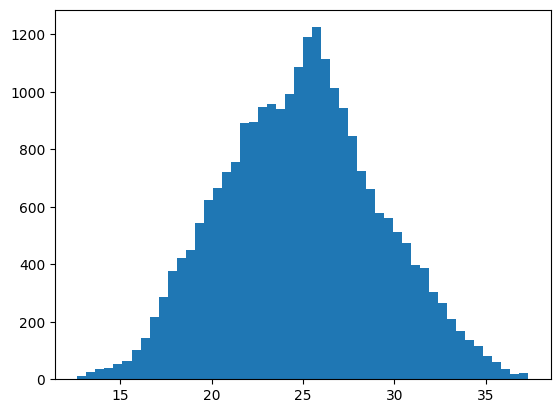

In [19]:
X = package.preprocessing.flatten_higher_triangular(torch.from_numpy(dataset[0:150,:,:]))
Y = package.preprocessing.flatten_higher_triangular(torch.from_numpy(dataset[300:462,:,:]))
d = generate_vector_distance_inter_zones(X,Y)
plt.hist(d.flatten(),bins=50)

In [60]:
dfc.shape

(156, 464, 82, 82)

Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie4.mp4


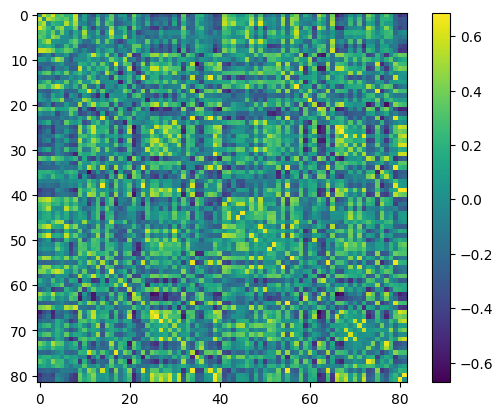

In [112]:
import matplotlib.animation as animation

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
for a in [4] :
    ims = []
    fig, ax = plt.subplots()
    for i in range(464):
        im = ax.imshow(dfc[a,i,:,:], animated=True)
        if i == 0:
            ax.imshow(dfc[a,i,:,:])  # show an initial one first
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    fig.colorbar(im, ax=ax)
    
    ani.save("/volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie.mp4")
    print("Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie{}.mp4".format(a))

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

In [11]:
l = np.zeros((464))
for i in range(464):
    l[i] = np.mean(np.abs(dfc[0,i,:,:]))
arg = np.argsort(l)

In [12]:
arg

array([ 50,  51, 275, 276, 274,  52,  49, 440, 273, 439, 277, 441, 134,
        53, 438, 135, 133, 442, 272, 178,  48, 179, 177, 278,  27,  54,
       443, 176,  26, 132,  28, 412, 413, 411,  25, 180, 437,  29, 175,
       410, 271, 414, 136, 444,  24,  55,  30, 279, 409, 174,  23, 445,
       131,  47, 415,  22,  17,  18,  16,  19,  15,  31, 446,  20, 181,
        21,  14,  56, 408, 270, 447,  13, 173, 342, 436,  57, 341,  32,
       280, 448, 416, 343,  58,  12,  59, 407, 137,  60, 172, 182, 269,
       340,  46,  33, 449, 130, 344,  61,  11, 291, 406, 281, 292, 290,
       417, 345, 435, 293, 450, 171, 192, 268, 294,  34, 295, 296, 289,
        62, 297, 193, 191, 339, 138, 391,  10, 346, 298, 390, 183, 405,
        45, 288, 282, 190, 299, 347, 267, 194, 170, 451, 142, 141, 392,
       139,  35, 389,  63, 140, 143, 418, 348, 300, 287,   9, 129, 189,
       283, 338, 404, 266, 349, 144, 434, 184, 207, 169, 208, 286, 350,
       284, 301, 285, 195, 188, 351, 145, 265,  44, 452,  36, 16

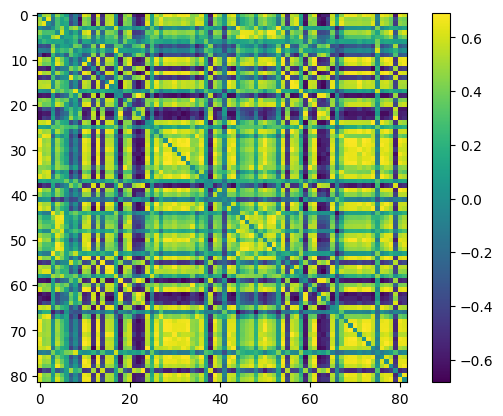

In [252]:
fig, ax = plt.subplots()
im = ax.imshow(dfc[0,0,:,:])
fig.colorbar(im,ax=ax)
plt.show()

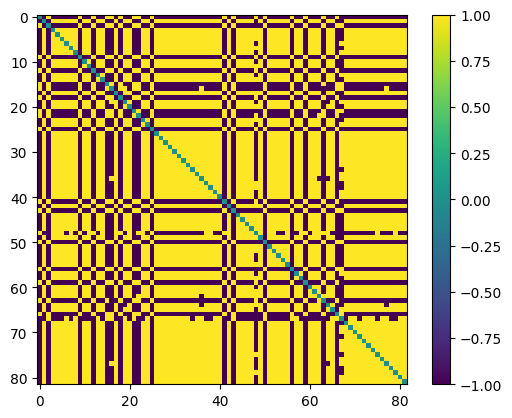

In [231]:
fig, ax = plt.subplots()
im = ax.imshow(np.sign(dfc[0,200,:,:]))
fig.colorbar(im,ax=ax)
plt.show()

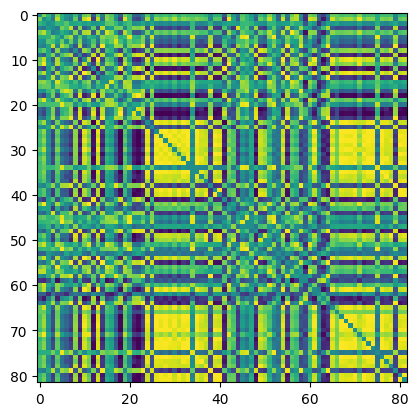

In [18]:
plt.imshow(dfc[0,300,:,:])

In [13]:
def comparaison_ligne(mat1,mat2):
    res = 0
    for i in range(len(mat1)):
        res += np.linalg.norm(mat1[i,:] - mat2[i,:])
        res += np.linalg.norm(mat1[:,i] - mat2[:,i])
    return res

In [22]:
ssim_dist = ssim(state1, dfc[0,300,:,:], data_range=2)
print(ssim_dist)

0.1835042706311571


In [14]:
state1 = dfc[0,118,:,:]
state2 = dfc[0,323,:,:]
state3 = dfc[0,200,:,:]
state4 = dfc[0,73,:,:]
states = [state1,state2,state3,state4]

In [317]:
comparaison_ligne(dfc[0,450,:,:],state2)

673.0963997338632

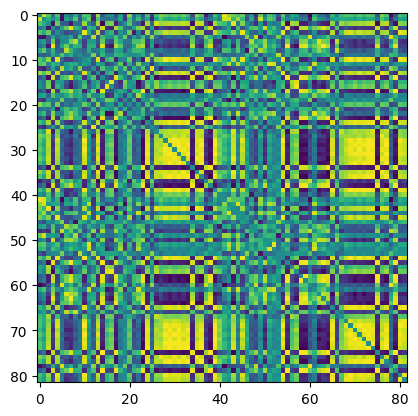

In [308]:
plt.imshow(dfc[0,450,:,:])

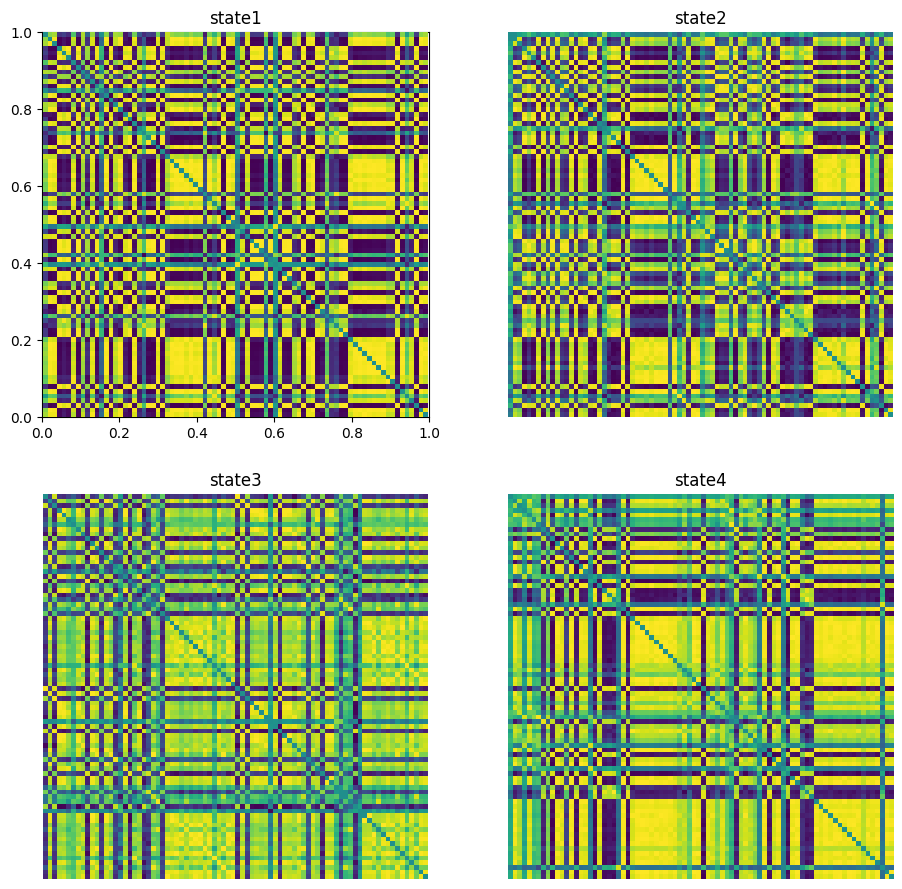

In [220]:
display(states,["state1","state2","state3","state4"])

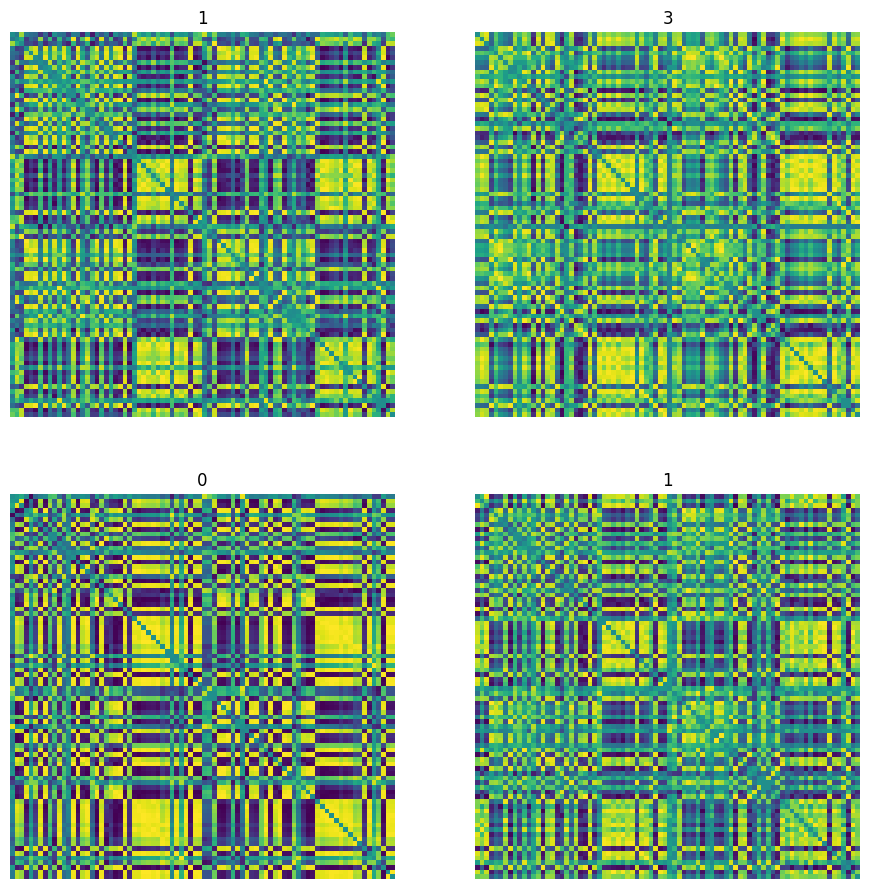

In [38]:
i,j,k,l = np.random.randint(0,464,4)
li_mat = [dfc[0,i,:,:],dfc[0,j,:,:],dfc[0,k,:,:],dfc[0,l,:,:]]
li_titles = [list_label[i],list_label[j],list_label[k],list_label[l]]
display(li_mat,li_titles)

In [25]:
list_label = []
for t in range(464):
    l = np.array([ssim(state, dfc[0,t,:,:], data_range=2) for state in states])
    list_label.append(np.argmax(l))

## Définition des états

In [73]:
fc_train = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc)))

In [134]:
state1_vector = torch.unsqueeze(fc_train[0,118,:],dim=0).type(torch.float32)
state2_vector = torch.unsqueeze(fc_train[0,323,:],dim=0).type(torch.float32)
state3_vector = torch.unsqueeze(fc_train[0,200,:],dim=0).type(torch.float32)
state4_vector = torch.unsqueeze(fc_train[0,73,:],dim=0).type(torch.float32)
states = torch.cat([state1_vector,state2_vector,state3_vector,state4_vector],dim=0)

In [114]:
a,b,c,d = np.random.randint(462,size = 4)
state1_vector = torch.unsqueeze(fc_train[0,a,:],dim=0).type(torch.float32)
state2_vector = torch.unsqueeze(fc_train[0,b,:],dim=0).type(torch.float32)
state3_vector = torch.unsqueeze(fc_train[0,c,:],dim=0).type(torch.float32)
state4_vector = torch.unsqueeze(fc_train[0,d,:],dim=0).type(torch.float32)
states_random = torch.cat([state1_vector,state2_vector,state3_vector,state4_vector],dim=0)

## Linear Regression

In [7]:
class MultipleLinearRegression(nn.Module):
    def __init__(self,states):
        super(MultipleLinearRegression, self).__init__()
        self.states = states
        self.coeff = nn.Parameter(torch.randn(len(states)))
    def forward(self,x):
        x = torch.matmul(self.coeff,self.states)
        return x 

In [8]:
# === Train === ###
def Train(net,target,nb_epochs,verbose = False):
    net.train()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

    # train loop
    for epoch in range(nb_epochs):
        train_correct = 0
        train_loss = 0
        compteur = 0

        output = net(net.coeff)

        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss

        compteur += 1

        if epoch % 10 == 0 and verbose : 
            print('Distance {:.4f}'.format(
            torch.sqrt(train_loss)))
            
    if verbose : 
        print('End of training.\n')
        
    return train_loss

In [137]:
train = package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc[0,:,:,:]))
list_losses = []
list_params = np.zeros((464,4))

for i in range(464):
    model = MultipleLinearRegression(states)
    train_loss = Train(model,train[i,:],100)
    list_losses.append(np.sqrt(train_loss.item()))
    list_params[i,:] = model.coeff.detach().numpy()


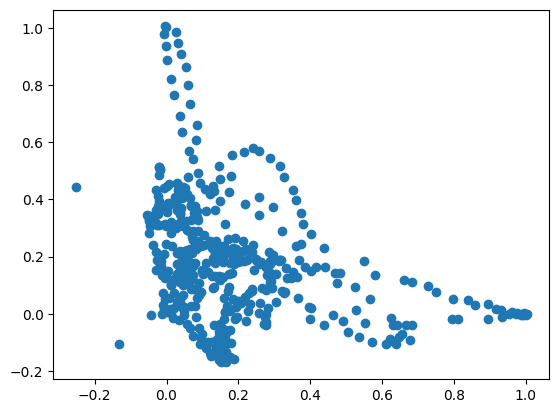

In [140]:
plt.scatter(list_params[:,0],list_params[:,3])

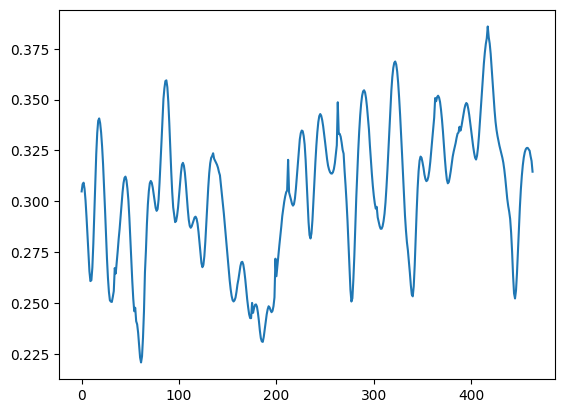

In [127]:
plt.plot(list_loss)

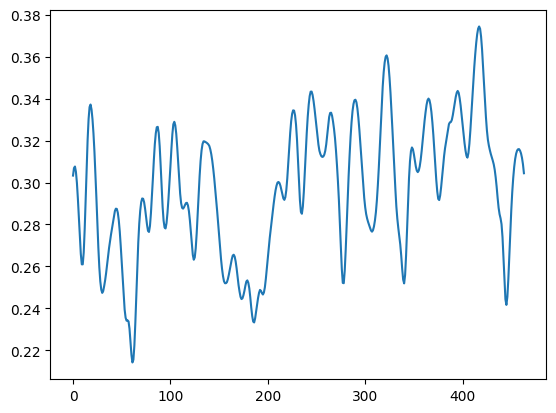

In [118]:
plt.plot(list_loss)

## Implémentation de CEBRA sur le dataset avec la metric SSIM

In [65]:
dfc[0,:,:,:].shape

(464, 82, 82)

In [145]:
fc_train = dfc[0:5,:,:,:].reshape((5,464,1,82,82))
distance = torch.from_numpy(package.preprocessing.generate_matrix_distance(fc_train,distance = "ssim"))

0
0
1
2
3
4
1
1
2
3
4
2
2
3
4
3
3
4
4
4


(array([5.600e+01, 1.900e+01, 1.000e+01, 3.600e+01, 1.300e+01, 1.800e+01,
        1.900e+01, 7.000e+00, 6.000e+00, 5.000e+00, 1.900e+01, 2.200e+01,
        1.300e+01, 1.300e+01, 5.000e+00, 1.200e+01, 2.000e+00, 1.100e+01,
        2.000e+01, 2.100e+01, 1.000e+01, 7.000e+00, 1.100e+01, 5.000e+00,
        1.200e+01, 1.200e+01, 2.000e+01, 8.000e+00, 1.600e+01, 7.000e+00,
        9.000e+00, 1.500e+01, 1.700e+01, 1.300e+01, 1.500e+01, 1.000e+01,
        1.000e+01, 1.100e+01, 2.200e+01, 1.500e+01, 1.800e+01, 2.100e+01,
        1.600e+01, 1.200e+01, 2.400e+01, 1.700e+01, 3.800e+01, 2.500e+01,
        5.700e+01, 5.000e+01, 6.400e+01, 8.100e+01, 9.700e+01, 1.150e+02,
        1.400e+02, 1.580e+02, 1.780e+02, 1.820e+02, 2.700e+02, 2.940e+02,
        3.290e+02, 3.650e+02, 3.910e+02, 4.260e+02, 4.830e+02, 5.670e+02,
        5.960e+02, 7.190e+02, 7.630e+02, 8.990e+02, 1.053e+03, 1.340e+03,
        1.446e+03, 1.633e+03, 1.853e+03, 2.087e+03, 2.325e+03, 2.432e+03,
        2.750e+03, 2.828e+03, 3.009e+0

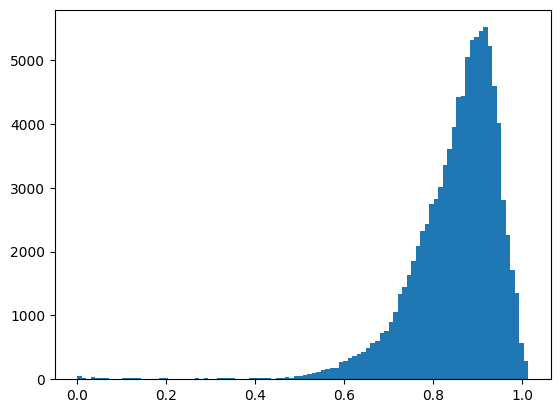

In [146]:
plt.hist(distance.flatten()[:100000],bins=100)

In [274]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        num_output * 1000,
    ),
    nn.GELU(),
    nn.Linear(int(num_output * 1000), num_output * 200),
    nn.GELU(),
    nn.Linear(int(num_output * 200), num_output * 60),
    nn.GELU(),
    nn.Linear(int(num_output * 60), num_output * 30),
    nn.GELU(),
    nn.Linear(int(num_output * 30), num_output),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [251]:
fc_train_vector.shape

(5, 464, 3321)

In [275]:
fc_train_vector = package.preprocessing.flatten_higher_triangular(torch.from_numpy(fc_train.reshape(5,464,82,82)))
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_vector)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 248,  distance = distance, time_delta = 20, matrix_delta = 0.5)

In [276]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [277]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 5.5128, Train accuracy 0.00%
Epoch 100
Train loss 4.6237, Train accuracy 0.00%
Epoch 200
Train loss 4.6755, Train accuracy 0.00%
Epoch 300
Train loss 4.6008, Train accuracy 0.00%
Epoch 400
Train loss 4.6509, Train accuracy 0.00%
Epoch 500
Train loss 4.6505, Train accuracy 0.00%
Epoch 600
Train loss 4.6524, Train accuracy 0.00%
Epoch 700
Train loss 4.6408, Train accuracy 0.00%
Epoch 800
Train loss 4.6184, Train accuracy 0.00%
Epoch 900
Train loss 4.6415, Train accuracy 0.00%


In [261]:
fc_dataset.neural.shape

torch.Size([5, 464, 3321])

(-1.0747262060642242,
 0.9507684528827667,
 -1.0989089727401733,
 1.097184133529663)

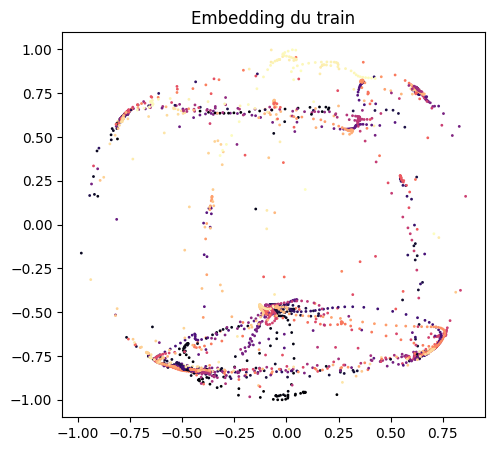

In [278]:
a,b,c = fc_dataset.neural.shape
data_print = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data_print)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
for i in [0,1,2,3,4]:
    ax1.scatter(fc_emb[i,:,1], fc_emb[i,:,2], cmap = "magma", c = np.arange(464), s=1)
#ax1.xticks() 
ax1.axis('on')

In [172]:
type(fc_emb)

numpy.ndarray

Text(0.5, 1.0, 'Elbow curve')

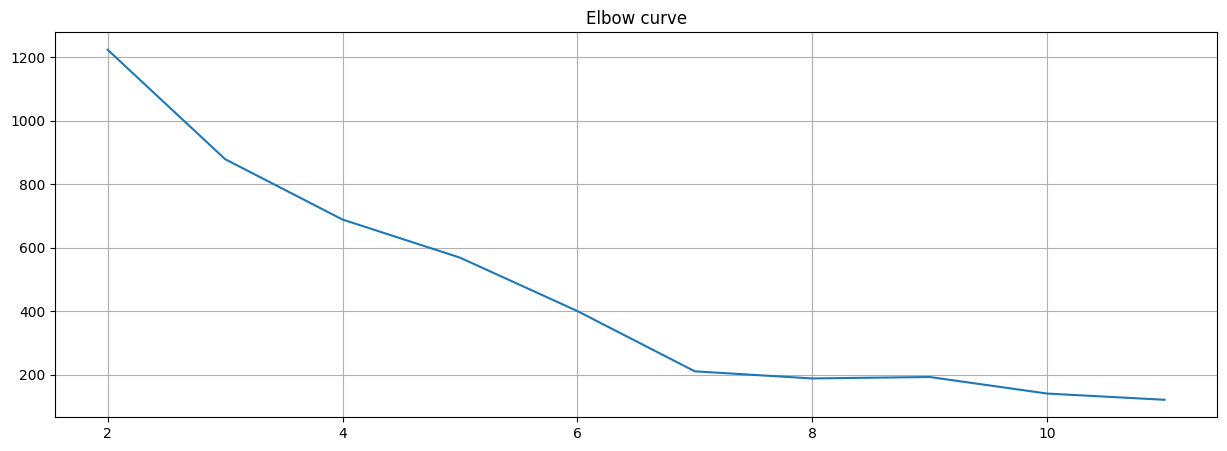

In [285]:
X = fc_emb.reshape(5*464,3)
distorsions = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k,n_init="auto")
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 12), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [293]:
kmeans = KMeans(n_clusters=2,n_init="auto")
Y = np.argmin(kmeans.fit_transform(X),axis=1)

In [197]:
type(fc_train)

numpy.ndarray

In [311]:
list_label = Y
data_mat = fc_train.reshape(5*464,82,82)
mean_states = np.array([np.mean(data_mat[Y == i],axis=0) for i in range(2)])

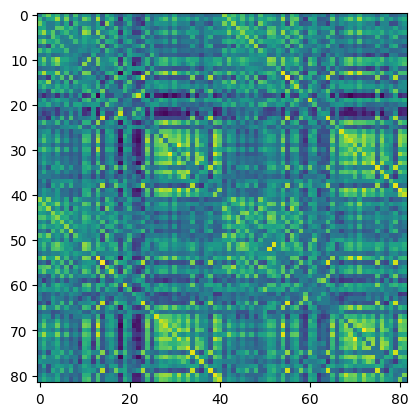

In [303]:
plt.imshow(mean_states[1])

(-1.0747262060642242,
 0.9507684528827667,
 -1.0989089727401733,
 1.097184133529663)

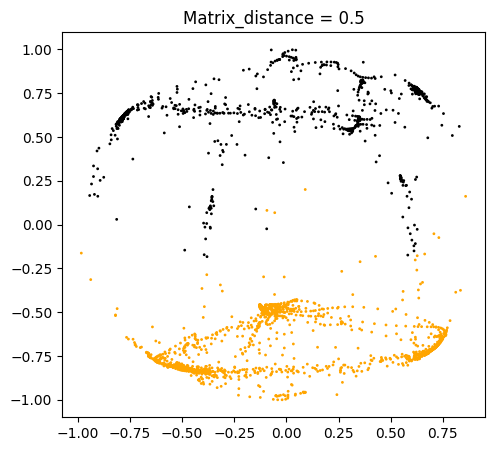

In [321]:
data_print = fc_emb.reshape(5*464,3)
labels_print = Y
fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title("Matrix_distance = 0.5")
colors = ["black",'red','green','blue','purple',"orange"]
ax1.scatter(data_print[:,1], data_print[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
ax1.axis('on')

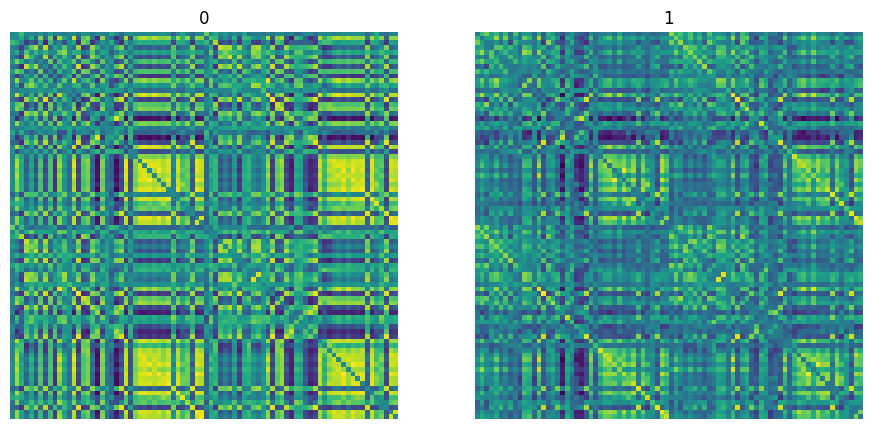

In [317]:
display(mean_states,np.arange(0,2))

## Implémentation de CEBRA sur le dataset avec la metric structure

In [7]:
fc_train = torch.from_numpy(dfc[0:11,:,:,:].reshape((11,464,1,82,82)))
distance = np.load("./DistanceMatrices/distance_matrix_11_sessions_structure.npy")

(array([1.62240e+04, 6.04400e+03, 5.41600e+03, 4.49600e+03, 4.12800e+03,
        3.80400e+03, 3.47400e+03, 3.49800e+03, 3.46400e+03, 3.47400e+03,
        3.43200e+03, 3.74200e+03, 4.39200e+03, 4.75400e+03, 5.70600e+03,
        6.40600e+03, 7.61800e+03, 8.13200e+03, 9.23400e+03, 1.04900e+04,
        1.19260e+04, 1.30800e+04, 1.43520e+04, 1.56700e+04, 1.76960e+04,
        1.94620e+04, 2.16240e+04, 2.45600e+04, 2.67280e+04, 2.85120e+04,
        3.22500e+04, 3.40320e+04, 3.84700e+04, 4.09500e+04, 4.53320e+04,
        4.97600e+04, 5.40760e+04, 5.92820e+04, 6.41920e+04, 7.05560e+04,
        7.62680e+04, 8.20300e+04, 9.00700e+04, 1.00132e+05, 1.10220e+05,
        1.20296e+05, 1.32680e+05, 1.45046e+05, 1.58842e+05, 1.73546e+05,
        1.90064e+05, 2.08820e+05, 2.27920e+05, 2.49532e+05, 2.71112e+05,
        2.95628e+05, 3.20744e+05, 3.47190e+05, 3.72974e+05, 3.95920e+05,
        4.20986e+05, 4.49020e+05, 4.74822e+05, 5.04622e+05, 5.32550e+05,
        5.60280e+05, 5.90760e+05, 6.16754e+05, 6.42

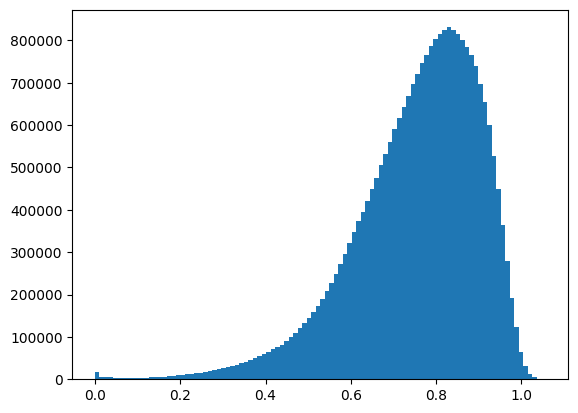

In [8]:
dist = distance.flatten()
plt.hist(dist,bins=100)

In [188]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        num_output,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

Question : comment choisir le matrix_delta ?
Si le matrix_delta est très petit, l'embedding ne formera pas de clusters de points distincts mais plutôt des formes continues (pourquoi??)
Si le matrix_delta est trop grand, l'embedding rapprochera trop de points différents et ne formera donc pas de clusters de points. 

In [189]:
fc_train = torch.squeeze(fc_train,dim=2)
fc_train_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_train))
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_vector)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 3000,  distance = torch.from_numpy(distance), time_delta = 1, matrix_delta = 0.55)

In [190]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [191]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 7.6191, Train accuracy 0.00%
Epoch 100
Train loss 7.2654, Train accuracy 0.00%
Epoch 200
Train loss 7.2610, Train accuracy 0.00%
Epoch 300
Train loss 7.2599, Train accuracy 0.00%


KeyboardInterrupt: 

/volatile/aurelien_stumpf_mascles/project/env/lib/python3.8/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(-1.0986169721428496,
 1.0907646974764158,
 -1.0995762613027271,
 1.0996294940384042)

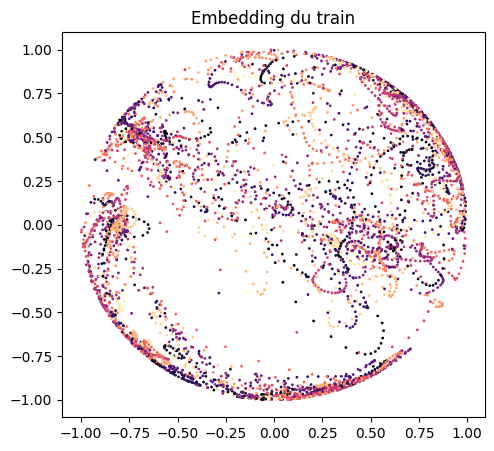

In [192]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
r = R.from_rotvec([1.3*np.pi/2, 1*np.pi/2, -1*np.pi/2])
fc_emb = r.apply(fc_emb)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
for i in [0,1,2,3,4,5,6,7,8,9,10]:
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = "magma", c = np.arange(464), s=1)
#ax1.xticks() 
ax1.axis('on')

(-1.1, 1.1, -1.0998615404412626, 1.0998615404412626)

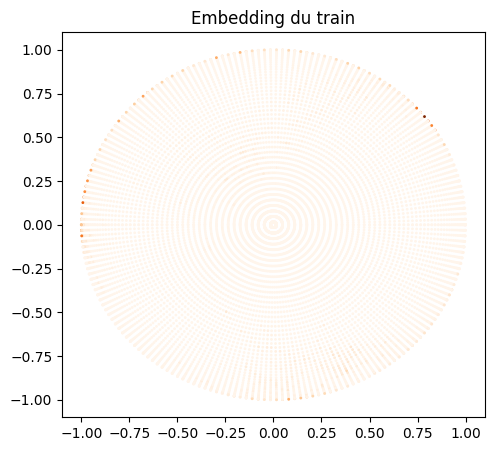

In [163]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,100),-np.linspace(0,np.pi,100))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)

def create_heat_sphere(fc_emb,sphere):
    heatmap = np.zeros(len(sphere))
    for idx in range(len(fc_emb)):
        accu_id = np.argmin(np.linalg.norm(sphere - fc_emb[idx,:],axis=1))
        heatmap[accu_id] += 1
    return heatmap 

heatmap = create_heat_sphere(fc_emb.reshape(11*464,3),sphere)

fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
ax1.scatter(sphere[:,0], sphere[:,1], cmap = "Oranges", c = heatmap, s=1)
#ax1.xticks() 
ax1.axis('on')


## KMeans 

Text(0.5, 1.0, 'Elbow curve')

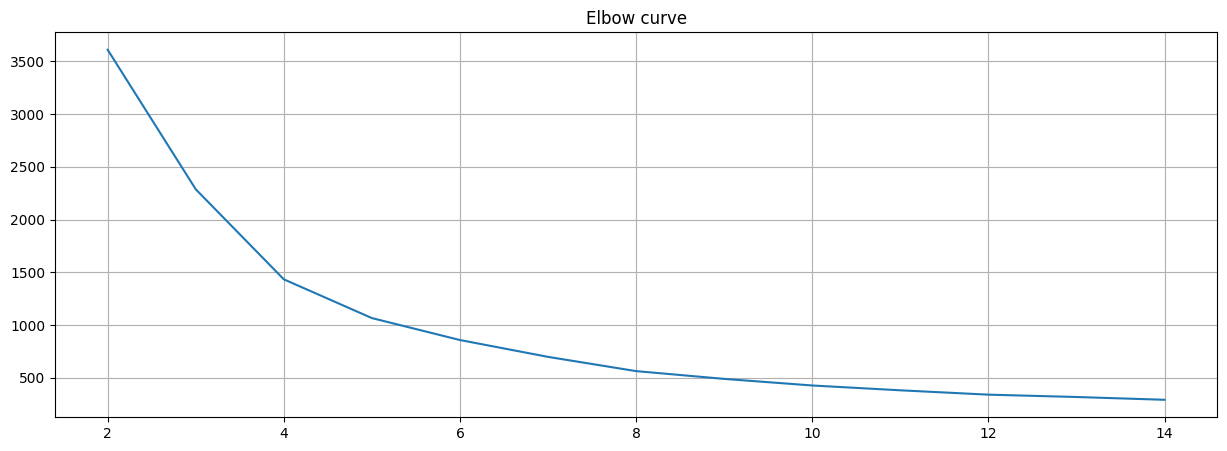

In [43]:
X = fc_emb.reshape(11*464,3)
distorsions = []
for k in range(2, 15):
    accu = 0
    for l in range(50):
        kmeans = KMeans(n_clusters=k,n_init="auto")
        kmeans.fit(X)
        accu += kmeans.inertia_
    distorsions.append(accu/50)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [507]:
kmeans = KMeans(n_clusters=6,n_init="auto")
Y = np.argmin(kmeans.fit_transform(X),axis=1)

(-1.0635177812232977,
 1.0978118390585307,
 -1.07451494038105,
 1.0987196117639542)

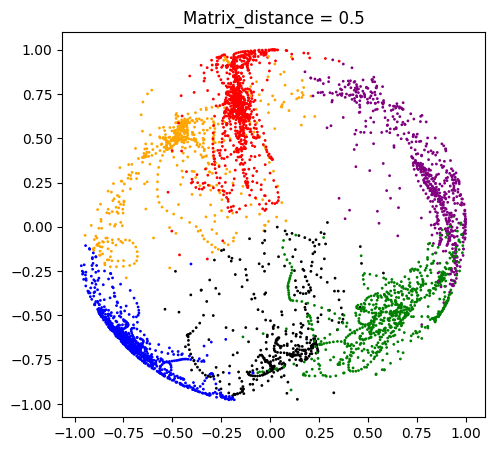

In [510]:
data_print = fc_emb.reshape(9*464,3)
r = R.from_rotvec([0, 0, 0.2*np.pi/2])
data_print = r.apply(data_print)
labels_print = Y
fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title("Matrix_distance = 0.5")
colors = ["black",'red','green','blue','purple',"orange"]
ax1.scatter(data_print[:,0], data_print[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
ax1.axis('on')

In [332]:
fc_train_vector.shape

torch.Size([6, 464, 3321])

In [521]:
package.preprocessing.structure(torch.from_numpy(dfc[8,114,:,:].reshape(1,82,82)),torch.from_numpy(mean_states[5,:,:].reshape(1,82,82)),val_range = 1)

tensor(0.0905, dtype=torch.float64)

In [513]:
list_label = Y
data_mat = fc_train.reshape(9*464,82,82).detach().numpy()
mean_states = np.array([np.mean(data_mat[Y == i],axis=0) for i in range(6)])
accu = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(mean_states.reshape(1,6,82,82)))).type(torch.float32)
states_positions = _compute_emissions_single(cebra_fc, accu)

In [526]:
np.unique(list_label)

array([0, 1, 2, 3, 4, 5])

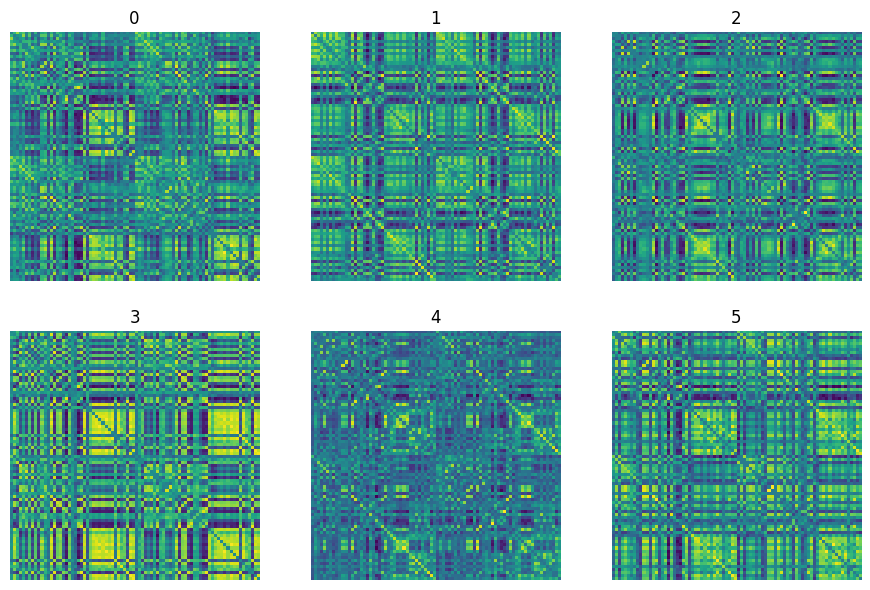

In [514]:
display(mean_states,np.arange(6))

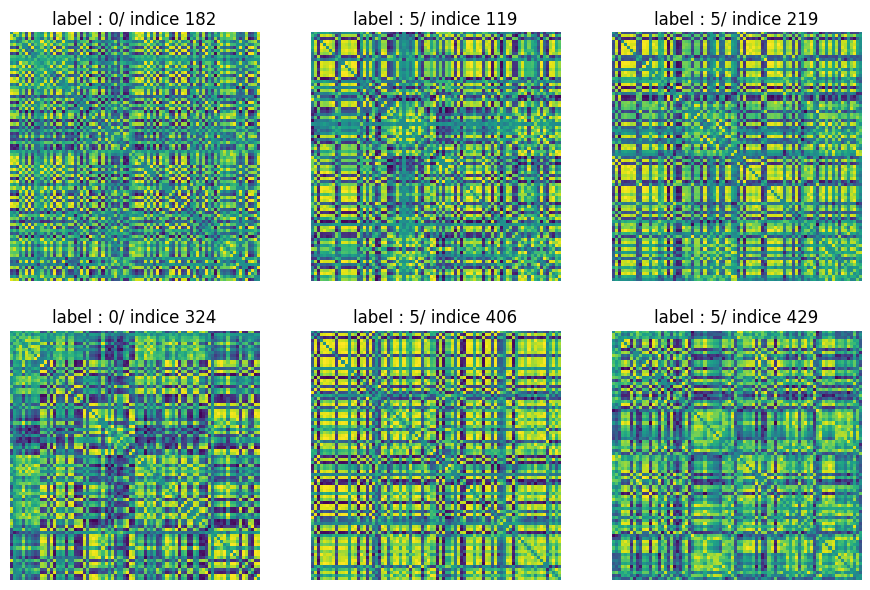

In [533]:
l = np.random.randint(0,464,6)
labels = list_label.reshape(9,464)
li_mat = [dfc[3,k,:,:] for k in l]
li_titles = ["label : " + str(labels[3,k]) + "/ indice {}".format(k) for k in l]
display(li_mat,li_titles)

In [534]:
count_states = np.array([len(data_mat[Y == i]) for i in range(6)])
print(count_states)

[406 909 755 889 656 561]


## MULTI-PROCESSING

In [12]:
import importlib
importlib.reload(package.preprocessing)

def STRUCTURE(x,y):
        return 1 - package.preprocessing.structure(x,y,is_batch = False,val_range = 2)

metric = STRUCTURE

def generator_matrix_distance(data,distance = "euclidean"):
    """
    Returns : 
        The distance matrix of the multi-session dataset containing the correlation matrices
        distance_matrix[session1,t1,session2,t2] = metric(data[session1,t1] - data[session2,t2])
    """

    if len(data.shape) == 4 : 
        time,_,_,_ = data.shape
        for t1 in range(time):
            for t2 in range(t1,time):
                yield t1,t2,data[session1,t1,:,:,:],data[session2,t2,:,:,:]
    else : 
        nb_session,time,_,_,_ = data.shape
        for session1 in range(nb_session):
            print(session1)
            for t1 in range(time):
                print(t1)
                for session2 in range(session1,nb_session):
                    for t2 in range(time):
                        yield session1,t1,session2,t2,data[session1,t1,:,:,:],data[session2,t2,:,:,:]

def generator_matrix_distance_follow(data):
    """
    Returns : 
        The distance matrix of the multi-session dataset containing the correlation matrices
        distance_matrix[session1,t1,session2,t2] = metric(data[session1,t1] - data[session2,t2])
    """

    if len(data.shape) == 4 : 
        time,_,_,_ = data.shape
        for t1 in range(time):
            for t2 in range(t1,time):
                yield t1,t2,data[session1,t1,:,:,:],data[session2,t2,:,:,:]
    else : 
        nb_session,time,_,_,_ = data.shape
        for session1 in range(nb_session):
            print(session1)

            if session1 == nb_session - 1 :
                for t1 in range(time):
                    print(t1)
                    for session2 in range(session1,nb_session):
                        for t2 in range(time):
                            yield session1,t1,session2,t2,data[session1,t1,:,:,:],data[session2,t2,:,:,:]
            
            else : 
                for t1 in range(time):
                    print(t1)
                    for t2 in range(time):
                        yield session1,t1,nb_session - 1,t2,data[session1,t1,:,:,:],data[nb_session - 1,t2,:,:,:]

In [8]:
def do_job(tasks_to_accomplish,distance,metric):
    compteur = 0
    while compteur < 5:
        time.sleep(5)
        try:
            '''
                try to get task from the queue. get_nowait() function will 
                raise queue.Empty exception if the queue is empty. 
                queue(False) function would do the same task also.
            '''
            task = tasks_to_accomplish.get_nowait()
            session1,t1,session2,t2,img1,img2 = task
            print("{},{},{},{}\n".format(session1,t1,session2,t2),end="")
            distance[session1,t1,session2,t2] = metric(img1,img2)
        except queue.Empty:
            print("Queue is empty\n",end = "")
            compteur += 1
    return True

def generate_items(generator, tasks_to_accomplish):
    for elem in generator : 
        while True :
            print("Taille de la queue : {}\n".format(tasks_to_accomplish.qsize()),end="")
            try : 
                tasks_to_accomplish.put_nowait(elem)
                time.sleep(5)
                break
            except :
                pass
    return True

def main():
    number_of_processes = 4
    tasks_to_accomplish = Queue(10)
    processes = []
    generator = generator_matrix_distance(fc_train,distance="structure")
    distance_matrix = np.zeros((2,464,2,464)) 

    # creating processes
    for w in range(number_of_processes):
        if w == 0 :
            p = Process(target=generate_items, args=(generator, tasks_to_accomplish))
            processes.append(p)
            print(p)
            p.start()
        else : 
            p = Process(target=do_job, args=(tasks_to_accomplish,distance_matrix,metric))
            processes.append(p)
            print(p)
            p.start()
        
    for p in processes : 
        if p.is_alive():
            print(p)

    # completing process
    for p in processes:
        if p.is_alive():
            print(p)
        p.join()

    return True


if __name__ == '__main__':
    main()
    active = multiprocessing.active_children()
    for child in active:
        child.terminate()

NameError: name 'fc_train' is not defined

(array([1.62240e+04, 6.04400e+03, 5.41600e+03, 4.49600e+03, 4.12800e+03,
        3.80400e+03, 3.47400e+03, 3.49800e+03, 3.46400e+03, 3.47400e+03,
        3.43200e+03, 3.74200e+03, 4.39200e+03, 4.75400e+03, 5.70600e+03,
        6.40600e+03, 7.61800e+03, 8.13200e+03, 9.23400e+03, 1.04900e+04,
        1.19260e+04, 1.30800e+04, 1.43520e+04, 1.56700e+04, 1.76960e+04,
        1.94620e+04, 2.16240e+04, 2.45600e+04, 2.67280e+04, 2.85120e+04,
        3.22500e+04, 3.40320e+04, 3.84700e+04, 4.09500e+04, 4.53320e+04,
        4.97600e+04, 5.40760e+04, 5.92820e+04, 6.41920e+04, 7.05560e+04,
        7.62680e+04, 8.20300e+04, 9.00700e+04, 1.00132e+05, 1.10220e+05,
        1.20296e+05, 1.32680e+05, 1.45046e+05, 1.58842e+05, 1.73546e+05,
        1.90064e+05, 2.08820e+05, 2.27920e+05, 2.49532e+05, 2.71112e+05,
        2.95628e+05, 3.20744e+05, 3.47190e+05, 3.72974e+05, 3.95920e+05,
        4.20986e+05, 4.49020e+05, 4.74822e+05, 5.04622e+05, 5.32550e+05,
        5.60280e+05, 5.90760e+05, 6.16754e+05, 6.42

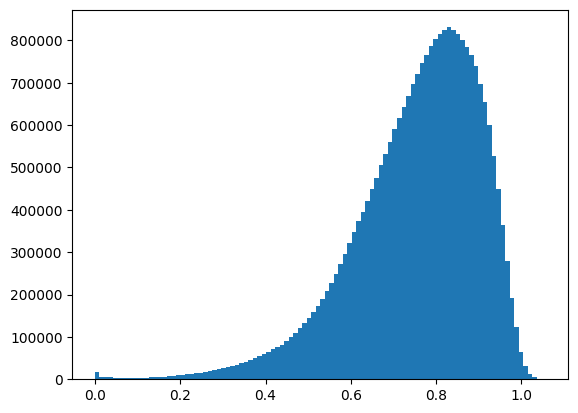

In [571]:
plt.hist(distance_matrix.flatten(),bins = 100)

In [567]:
dist = np.zeros((10,464,10,464))
dist = distance[:10,:,:,:]

In [569]:
distance = np.load("./DistanceMatrices/distance_matrix_10_sessions_structure.npy")
distance_matrix = np.zeros((11,464,11,464)) 
fc_train = torch.from_numpy(dfc[0:11,:,:,:].reshape((11,464,1,82,82)))
distance_matrix[:10,:,:10,:] = distance
real_size = min(11, 82, 82) # window should be atleast 11x11 

def costly_function(elem,distance_matrix):
    session1,t1,session2,t2,img1,img2 = elem
    accu = metric(img1,img2)
    distance_matrix[session1,t1,session2,t2] = accu
    distance_matrix[session2,t2,session1,t1] = accu

generator = generator_matrix_distance_follow(fc_train)
parallel = Parallel(n_jobs=3,require='sharedmem',max_nbytes=1e5)
parallel(delayed(costly_function)(elem,distance_matrix) for elem in generator)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [9]:
np.save(file = "./DistanceMatrices/distance_matrix_11_sessions_structure.npy",arr = distance_matrix)

NameError: name 'distance_matrix' is not defined

In [15]:
dfc.shape

(156, 464, 82, 82)

In [16]:
#distance = np.load("./DistanceMatrices/distance_matrix_10_sessions_structure.npy")
n = 12

def costly_function(elem,distance_matrix):
    session1,t1,session2,t2,img1,img2 = elem
    accu = metric(img1,img2)
    distance_matrix[session1,t1,session2,t2] = accu
    distance_matrix[session2,t2,session1,t1] = accu

for i in range(11,n):
    print("Début de la session {}".format(i))
    distance_matrix = np.zeros((i+1,464,i+1,464)) 
    distance = np.load("./DistanceMatrices/awake/distance_matrix_{}_sessions_structure.npy".format(i))
    fc_train = torch.from_numpy(dfc[0:i+1,:,:,:].reshape((i+1,464,1,82,82)))
    distance_matrix[:i,:,:i,:] = distance
    generator = generator_matrix_distance_follow(fc_train)
    parallel = Parallel(n_jobs=-1,require='sharedmem',max_nbytes=1e5)
    parallel(delayed(costly_function)(elem,distance_matrix) for elem in generator)
    np.save(file = "./DistanceMatrices/awake/distance_matrix_{}_sessions_structure.npy".format(i+1),arr = distance_matrix)

Début de la session 11
0
0
1
2
3
4
5
6
7
8
9


## Comparaison avec la matrice structurelle

In [460]:
structural_matrix = np.loadtxt("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/structural.txt")

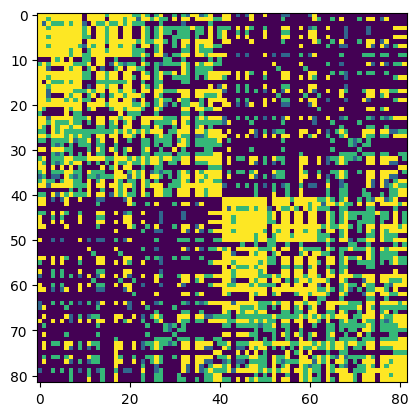

In [461]:
plt.imshow(structural_matrix)

In [222]:
np.max(structural_matrix)

3.0

In [223]:
mean_states_absolute = torch.from_numpy(np.abs(mean_states).reshape(8,1,82,82))
accu_mat = torch.from_numpy(structural_matrix / 4)
for i in range(len(mean_states_absolute)):
    accu = package.preprocessing.structure(mean_states_absolute[i,:,:,:],accu_mat,val_range = 1)
    print("Etat {} : {}".format(i,accu))

Etat 0 : 0.18139768583109514
Etat 1 : 0.10739385606161996
Etat 2 : 0.11456746717876228
Etat 3 : 0.13220034371583425
Etat 4 : 0.1269455308080382
Etat 5 : 0.22720756273815854
Etat 6 : 0.0750717781372075
Etat 7 : 0.24052087744914283


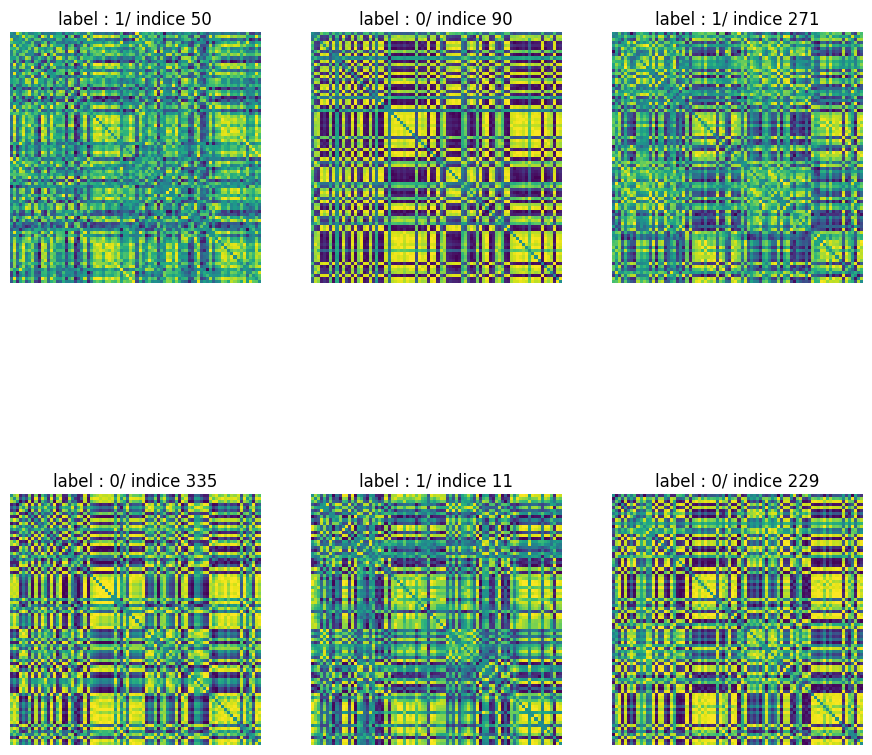

In [319]:
l = np.random.randint(0,464,6)
li_mat = [dfc[0,k,:,:] for k in l]
li_titles = ["label : " + str(list_label[k]) + "/ indice {}".format(k) for k in l]
display(li_mat,li_titles)

## Etude des transitions

(0.0, 8.0)

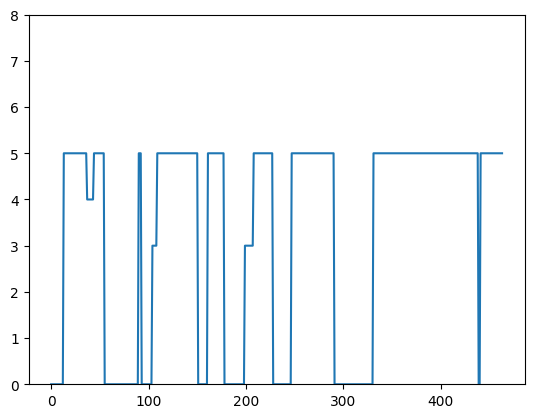

In [545]:
labels = list_label
session = fc_emb[6,:]
labels_by_session = labels.reshape(9,464)
plt.plot(labels_by_session[3,:])
plt.ylim(0,8)

In [287]:
def trunc(a, x):
    int1 = int(a * (10**x))/(10**x)
    return float(int1)

In [549]:
transition_list = []
for a in range(8):
    for i in range(463):
        session = fc_emb[a,:,:]
        labels = np.argmin(kmeans.transform(session),axis=1) 
        transition = (labels[i],labels[i+1])
        if not(transition in transition_list) and transition[0] != transition[1]:
            transition_list.append(transition)

transition_count = {key: 0 for key in transition_list}
for a in range(8):
    for i in range(463):
        session = fc_emb[a,:,:]
        labels = np.argmin(kmeans.transform(session),axis=1) 
        transition = (labels[i],labels[i+1])
        if transition[0] != transition[1]:
            transition_count[transition] += 1

dist = {key: 0 for key in transition_list}
mean_states_absolute = torch.from_numpy(np.abs(mean_states).reshape(6,1,82,82))
for edge in transition_list:
    dist[edge] = trunc(package.preprocessing.structure(mean_states_absolute[edge[0],:,:,:],mean_states_absolute[edge[1],:,:,:],val_range = 1).item(),2)


In [450]:
dist

{(2, 6): 0.37,
 (6, 2): 0.37,
 (2, 1): 0.44,
 (1, 2): 0.44,
 (6, 4): 0.45,
 (4, 5): 0.42,
 (5, 1): 0.25,
 (1, 5): 0.25,
 (5, 4): 0.42,
 (1, 6): 0.43,
 (6, 1): 0.43,
 (4, 3): 0.54,
 (3, 6): 0.46,
 (4, 1): 0.47,
 (4, 6): 0.45,
 (5, 0): 0.31,
 (0, 5): 0.31,
 (0, 3): 0.4,
 (3, 4): 0.54,
 (3, 0): 0.4,
 (4, 0): 0.55,
 (0, 4): 0.55,
 (0, 2): 0.43,
 (2, 3): 0.25}

In [451]:
transition_count

{(2, 6): 13,
 (6, 2): 9,
 (2, 1): 5,
 (1, 2): 7,
 (6, 4): 4,
 (4, 5): 9,
 (5, 1): 5,
 (1, 5): 5,
 (5, 4): 9,
 (1, 6): 8,
 (6, 1): 9,
 (4, 3): 7,
 (3, 6): 1,
 (4, 1): 1,
 (4, 6): 2,
 (5, 0): 1,
 (0, 5): 1,
 (0, 3): 10,
 (3, 4): 6,
 (3, 0): 11,
 (4, 0): 9,
 (0, 4): 9,
 (0, 2): 1,
 (2, 3): 1}

In [452]:
edges

[(0, 6),
 (6, 3),
 (3, 6),
 (6, 2),
 (2, 6),
 (2, 5),
 (5, 2),
 (2, 0),
 (0, 5),
 (5, 0),
 (3, 4),
 (4, 0),
 (5, 7),
 (7, 5),
 (0, 3),
 (3, 1),
 (1, 3),
 (0, 4),
 (1, 7),
 (4, 5),
 (7, 4),
 (4, 7),
 (7, 1)]

In [321]:
d

{0: array([[ 1., -1.,  1.]], dtype=float32),
 1: array([[-1.,  1., -1.]], dtype=float32),
 2: array([[-1., -1., -1.]], dtype=float32),
 3: array([[-1.,  1.,  1.]], dtype=float32),
 4: array([[1., 1., 1.]], dtype=float32),
 5: array([[ 1., -1., -1.]], dtype=float32),
 6: array([[-1., -1.,  1.]], dtype=float32),
 7: array([[ 1.,  1., -1.]], dtype=float32)}

In [551]:
transition_count

{(3, 5): 13,
 (5, 3): 9,
 (3, 0): 3,
 (0, 3): 5,
 (5, 4): 5,
 (4, 0): 4,
 (0, 4): 3,
 (0, 5): 11,
 (5, 0): 11,
 (4, 5): 4,
 (1, 3): 1,
 (3, 1): 1,
 (1, 5): 2,
 (5, 1): 2,
 (1, 4): 2,
 (4, 1): 2,
 (2, 4): 18,
 (4, 2): 18,
 (2, 3): 2,
 (3, 2): 2}

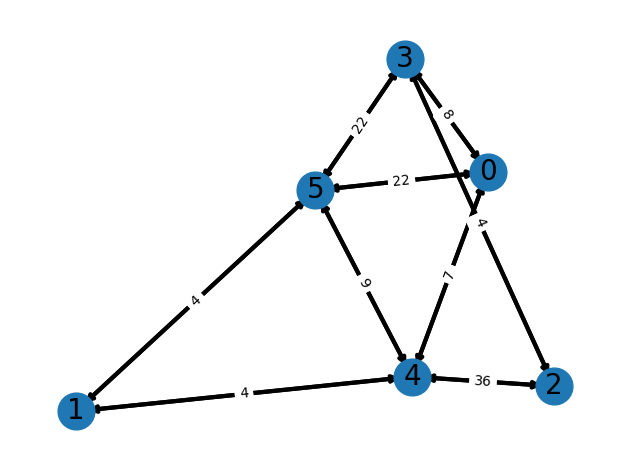

In [554]:
G = nx.DiGraph()

transitions = [edge for edge in transition_list if transition_count[edge] > 1]
edges = transitions

for edge in edges : 
    G.add_edge(edge[0], edge[1], weight=transition_count[edge]+transition_count[(edge[1],edge[0])])

pos = nx.spring_layout(G, seed=7)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=transitions, width=3, arrowstyle="->",arrowsize=10)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


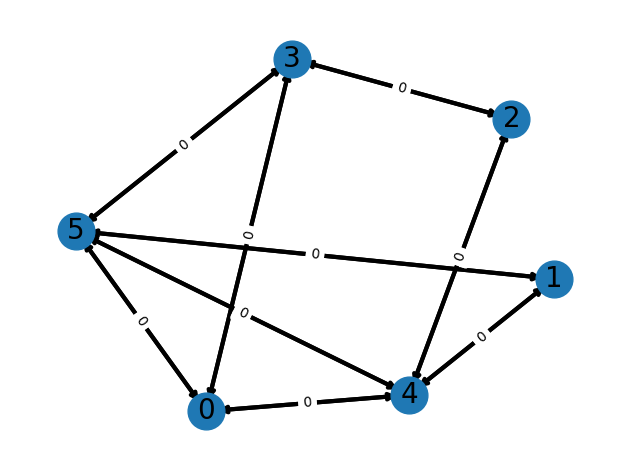

In [548]:
G = nx.DiGraph()

transitions = [edge for edge in transition_list if transition_count[edge] > 1]
edges = transitions

for edge in edges : 
    G.add_edge(edge[0], edge[1], weight=(dist[edge]))

pos = nx.spring_layout(G, seed = 1)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=transitions, width=3, arrowstyle="->",arrowsize=10)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

{(0, 6): Text(0.1610747396911919, 0.22825355693473542, '7'),
 (0, 5): Text(0.42863127007557167, -0.0994602840073811, '4'),
 (0, 3): Text(-0.17812697028754318, 0.3653122352450129, '4'),
 (0, 4): Text(0.27967970640901363, 0.49404771232443095, '3'),
 (6, 3): Text(-0.3744502438531275, 0.2732819794288015, '11'),
 (6, 2): Text(0.39725135142907136, 0.021950917686167255, '10'),
 (3, 6): Text(-0.3744502438531275, 0.2732819794288015, '5'),
 (3, 4): Text(-0.2558452771353057, 0.539076134818497, '3'),
 (3, 1): Text(-0.8568259769159312, 0.016653485332681434, '6'),
 (2, 6): Text(0.39725135142907136, 0.021950917686167255, '10'),
 (2, 5): Text(0.6648078818134511, -0.3057629232559493, '2'),
 (2, 0): Text(0.5935746249946556, 0.1139811735023786, '2'),
 (5, 2): Text(0.6648078818134511, -0.3057629232559493, '3'),
 (5, 0): Text(0.42863127007557167, -0.0994602840073811, '7'),
 (5, 7): Text(0.17989491907784685, -0.5326521153432793, '7'),
 (4, 0): Text(0.27967970640901363, 0.49404771232443095, '5'),
 (4, 5): Te

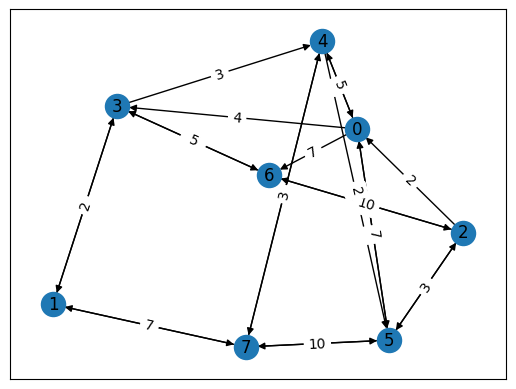

In [356]:
pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)